# 可解释的归一化卷积

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import PIL.Image as Image
import numpy as np
import torchvision.transforms as transforms

c:\Users\dongl\.conda\envs\d2l\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] 找不到指定的程序。
  warn(f"Failed to load image Python extension: {e}")


In [2]:
mario = Image.open("images/mario.png")
mario_gray = mario.convert("L")
template = Image.open("images/template16x16.png")
template_gray = template.convert("L")

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])
mario_tensor = transform(mario_gray)
template_tensor = transform(template_gray)
mario_tensor.shape, template_tensor.shape

(torch.Size([1, 240, 225]), torch.Size([1, 16, 16]))

In [4]:
mario_tensor.mean(), mario_tensor.std(), template_tensor.mean(), template_tensor.std()

(tensor(0.1561), tensor(0.2291), tensor(0.2312), tensor(0.2633))

## 模型

我们发现一个有意思的点就是完全不用做原图像的归一化，而是只做卷积核的归一化即可。

$$
\mathbf{R}(x,y)=\frac{\sum_{x',y'}(\mathbf{T}(\mathbf{x'},\mathbf{y'})\cdot\mathbf{I}(\mathbf{x}+\mathbf{x'},\mathbf{y}+\mathbf{y'}))}{\sqrt{\sum_{x',y'}\mathbf{T}(\mathbf{x'},\mathbf{y'})^2}}
$$

相比于之前的余弦相似度的归一化，我们这里直接将template经过一个layernorm即可变为N(0,1)的分布

In [5]:
class ConvNorm(nn.Module):
    def __init__(self, template_shape):
        super(ConvNorm, self).__init__()
        self.layer_norm_t = nn.LayerNorm(template_shape)

    def forward(self, x, template):
        return F.conv2d(x, self.layer_norm_t(template))

In [6]:
model = ConvNorm(template_shape=[1, 16, 16])

In [7]:
with torch.no_grad():
    print(model.layer_norm_t(template_tensor.unsqueeze(0)).mean(), model.layer_norm_t(template_tensor.unsqueeze(0)).std())

tensor(4.4703e-08) tensor(1.0019)


In [8]:
with torch.no_grad():
    R_CCORR_NORM = model(mario_tensor.unsqueeze(0), template_tensor.unsqueeze(0))

In [9]:
R_CCORR_NORM.max(), R_CCORR_NORM.min()

(tensor(67.2618), tensor(-41.5050))

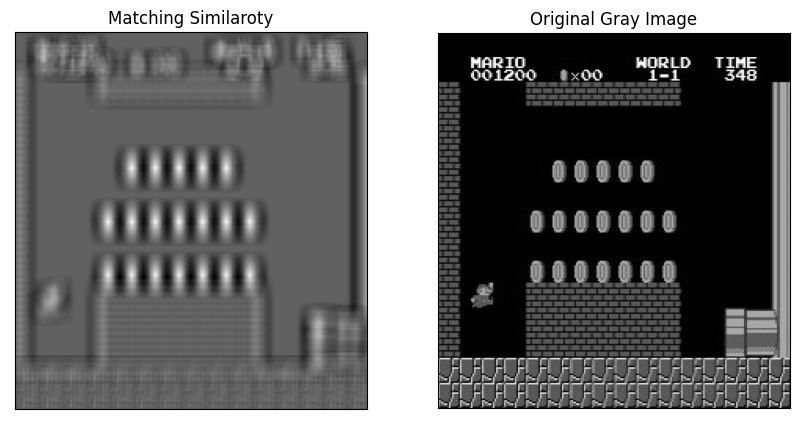

In [10]:
R_CCORR_NORM = R_CCORR_NORM.numpy().squeeze()
mario_gray_np = mario_tensor.numpy().squeeze()
import matplotlib.pyplot as plt
plt.figure("Matching Similaroty vs Original Gray Image", figsize=(10, 5))
plt.subplot(121),plt.imshow(R_CCORR_NORM,cmap = 'gray')
plt.title('Matching Similaroty'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(mario_gray_np,cmap = 'gray')
plt.title('Original Gray Image'), plt.xticks([]), plt.yticks([])
plt.show()

Found 19 matches


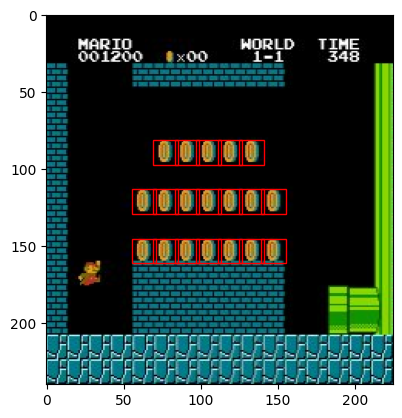

In [11]:
import matplotlib.patches as patches
plt.imshow(mario)
threshold = 60
loc = np.where( R_CCORR_NORM > threshold)
print(f"Found {len(loc[0])} matches")
_ , h, w = template_tensor.shape
for pt in zip(*loc[::-1]):
    # print(pt)
    rect = patches.Rectangle(pt, w, h, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()

## 归一化输出

我们的网络由于是一层接一层的所以建议在下一层之前就已经归一化

In [12]:
class ConvNormNorm(nn.Module):
    def __init__(self, input_shape, template_shape):
        super(ConvNormNorm, self).__init__()
        self.layer_norm_t = nn.LayerNorm(template_shape)
        output_shape = [input_shape[0], input_shape[1] - template_shape[1] + 1, input_shape[2] - template_shape[2] + 1]
        self.layer_norm_o = nn.LayerNorm(output_shape)

    def forward(self, x, template):
        return self.layer_norm_o(F.conv2d(x, self.layer_norm_t(template)))

In [13]:
model2 = ConvNormNorm(input_shape=[1, 240, 225], template_shape=[1, 16, 16])

In [14]:
with torch.no_grad():
    R_CCORR_NORM2 = model2(mario_tensor.unsqueeze(0), template_tensor.unsqueeze(0))

In [15]:
R_CCORR_NORM.mean(), R_CCORR_NORM.std(), R_CCORR_NORM2.mean(), R_CCORR_NORM2.std()

(-0.19143125, 9.709508, tensor(-1.9376e-09), tensor(1.0000))

In [16]:
R_CCORR_NORM.max(), R_CCORR_NORM.min(), R_CCORR_NORM2.max(), R_CCORR_NORM2.min()

(67.26183, -41.505043, tensor(6.9471), tensor(-4.2550))

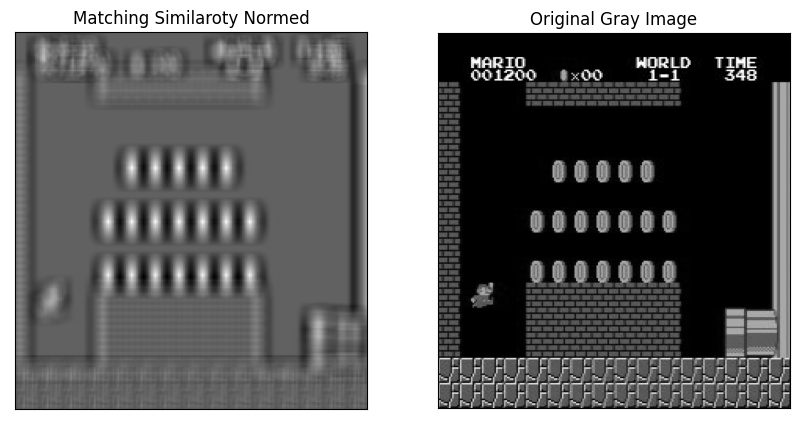

In [17]:
R_CCORR_NORM2 = R_CCORR_NORM2.numpy().squeeze()
mario_gray_np = mario_tensor.numpy().squeeze()
import matplotlib.pyplot as plt
plt.figure("Matching Similaroty vs Original Gray Image", figsize=(10, 5))
plt.subplot(121),plt.imshow(R_CCORR_NORM2,cmap = 'gray')
plt.title('Matching Similaroty Normed'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(mario_gray_np,cmap = 'gray')
plt.title('Original Gray Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [25]:
# 将R_CCORR_NORM2中的值归一化到0-255
R_CCORR_NORM2_A = (R_CCORR_NORM2 - R_CCORR_NORM2.min()) / (R_CCORR_NORM2.max() - R_CCORR_NORM2.min()) * 255
R_CCORR_NORM2_A = R_CCORR_NORM2_A.astype(np.uint8)
coin_sim = Image.fromarray(R_CCORR_NORM2_A)
coin_sim.save("images/coin_sim.png")

In [24]:
coin_sim = Image.open("images/coin_sim.png")
coin_sim_np = np.array(coin_sim)
coin_sim_np.shape

(225, 210)

Found 19 matches


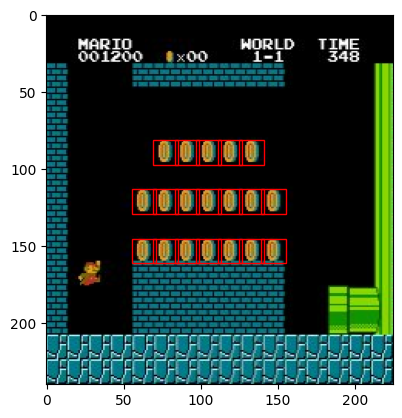

In [ ]:
import matplotlib.patches as patches
plt.imshow(mario)
threshold = 6
loc = np.where( R_CCORR_NORM2 > threshold)
print(f"Found {len(loc[0])} matches")
_ , h, w = template_tensor.shape
for pt in zip(*loc[::-1]):
    # print(pt)
    rect = patches.Rectangle(pt, w, h, linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()